In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [37]:
train_1 = pd.read_csv('data/scenario_1/train.csv')
test_1 = pd.read_csv('data/scenario_1/test.csv')
train_2 = pd.read_csv('data/scenario_2/train.csv')
test_2 = pd.read_csv('data/scenario_2/test.csv')
train_3 = pd.read_csv('data/scenario_3/train.csv')
test_3 = pd.read_csv('data/scenario_3/test.csv')

trains = [train_1['price'],train_2['price'],train_3['price']]
tests = [test_1['price'],test_2['price'],test_3['price']]

In [38]:
def build_model(train_data):
      # Initial approximation of parameters
    Ps = [7,8,9]
    Qs = [7,9]
    d=[1]
    parameters = product(Ps,d,Qs)
    parameters_list = list(parameters)

    # Model Selection
    results = []
    for param in parameters_list:
        try:
            model = ARIMA(train_data, order=(param[0], param[1], param[2])).fit()
        except ValueError:
            print(parameters_list)
            continue
        results.append([model,param])
    return results    

In [39]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

def mape_model(test,model):
         pred = model.forecast(steps=len(test))
         return mean_absolute_percentage_error(test,pred)

In [40]:
scen_models_res = []

# build model of all scenarios
for train in trains:
    models_res = build_model(train)
    scen_models_res.append(models_res)

In [52]:
evaluate_table = pd.DataFrame(columns=['Model','Scenario','MAPE'])
# calculate MAPE of all possible models * screnarios
for scen in range(0,3):
     test_scen = tests[scen]
     for par_num in range(0,6):
      model_scen = scen_models_res[scen][par_num][0]
      mape = mape_model(test_scen,model_scen)
      params_model = scen_models_res[scen][par_num][1]
      evaluate_table.loc[len(evaluate_table)] = [params_model,scen,mape]
     
evaluate_table = evaluate_table.pivot(index='Model',values='MAPE',columns='Scenario')

evaluate_table.index.name = None

evaluate_table.columns = ['Scenario 1','Scenario 2','Scenario 3']

# print(evaluate_table.to_csv('./result/evaluate-models.csv'))

evaluate_table

,Scenario 1,Scenario 2,Scenario 3
"(7, 1, 7)",2.484014,3.221262,0.841848
"(7, 1, 9)",2.166798,3.221364,0.406080
"(8, 1, 7)",2.762035,3.246296,0.423542
"(8, 1, 9)",2.409949,3.226004,0.548837
"(9, 1, 7)",2.235927,3.224270,0.332102
"(9, 1, 9)",2.424587,3.184966,0.519813


In [76]:
best_model = scen_models_res[2][1][0]

In [80]:
type(best_model.summary())

statsmodels.iolib.summary.Summary

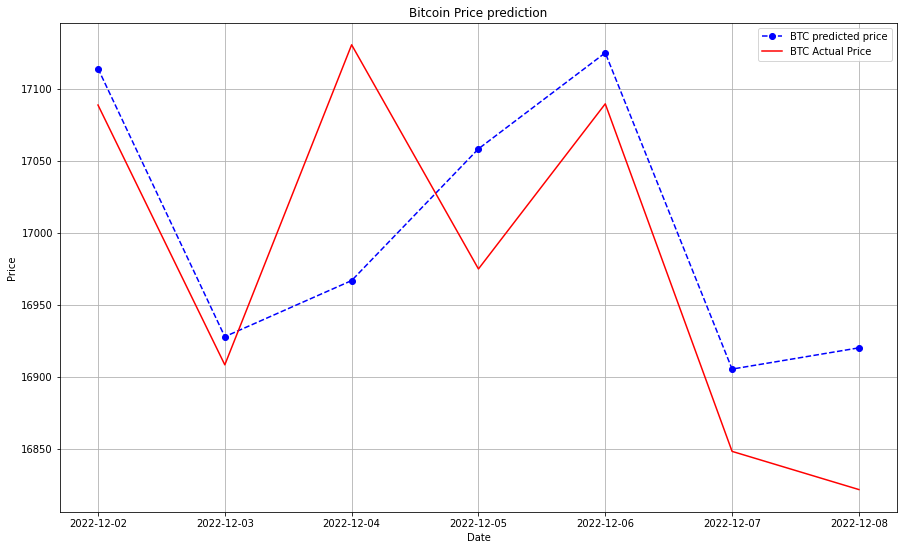

In [77]:
plt.figure(figsize=(15,9))
plt.grid(True)

timeline_forecast = test_3['Date']
actual_price = test_3['price']

plt.plot(timeline_forecast, best_model.forecast(steps=len(timeline_forecast)), color='blue', marker='o', linestyle='dashed',label='BTC predicted price')
plt.plot(timeline_forecast, actual_price, color ='red', label='BTC Actual Price')

plt.title('Bitcoin Price prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
